In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm

from arch import arch_model
from matplotlib import pyplot as plt

%matplotlib inline

In [2]:
price_df = pd.read_csv('data/raw/Housing_SalePrice_US.csv')
price_df.head()

,DATE,MSPUS
0,1963-01-01,17800.0
1,1963-04-01,18000.0
2,1963-07-01,17900.0
3,1963-10-01,18500.0
4,1964-01-01,18500.0


In [3]:
# Datetime objects are easier to work with

print(price_df.info())

price_df['DATE'] = pd.to_datetime(price_df['DATE'], format='%Y-%m-%d')

# After
price_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 237 entries, 0 to 236
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   DATE    237 non-null    object 
 1   MSPUS   237 non-null    float64
dtypes: float64(1), object(1)
memory usage: 3.8+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 237 entries, 0 to 236
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   DATE    237 non-null    datetime64[ns]
 1   MSPUS   237 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 3.8 KB


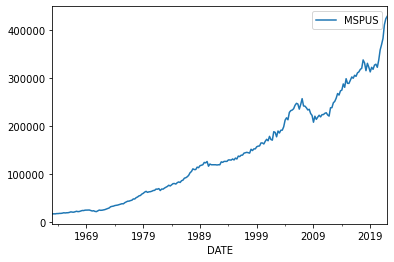

In [4]:
price_df.plot.line('DATE', 'MSPUS')

plt.savefig('figures/MSPUS_pandas.png')
plt.show()

In [5]:
macro_df = pd.read_csv('data/raw/Macroecon_US.csv')

# Get the Date column in to a format strftime can handle
macro_df['Date'] = macro_df['Date'].astype('str') + '.01'  # Assume data is from the first of each month
macro_df['Date'] = macro_df['Date'].str.replace('.', '-')
print(macro_df.head())

# Convert to datetime object
macro_df['Date'] = pd.to_datetime(macro_df['Date'], format='%Y.%m')

macro_df.head()

         Date  S&P Comp.  Dividend  Earnings    Consumer Price Index CPI  \
0  1871-01-01       4.44      0.26       0.4                       12.46   
1  1871-02-01       4.50      0.26       0.4                       12.84   
2  1871-03-01       4.61      0.26       0.4                       13.03   
3  1871-04-01       4.74      0.26       0.4                       12.56   
4  1871-05-01       4.86      0.26       0.4                       12.27   

   Date Fraction    Long Interest Rate GS10  Real Price  Real Dividend  \
0          1871.04                     5.32      103.43           6.06   
1          1871.13                     5.32      101.72           5.88   
2          1871.21                     5.33      102.68           5.79   
3          1871.29                     5.33      109.58           6.01   
4          1871.38                     5.33      114.97           6.15   

   Real Total Return Price   ...  Excess CAPE Yield  \
0                   103.43   ...           

/tmp/ipykernel_14018/2529911229.py:5: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  macro_df['Date'] = macro_df['Date'].str.replace('.', '-')


,Date,S&P Comp.,Dividend,Earnings,Consumer Price Index CPI,Date Fraction,Long Interest Rate GS10,Real Price,Real Dividend,Real Total Return Price,...,Excess CAPE Yield,Monthly Total Bond Returns,Real Total Bond Returns,10 Year Annualized Stock Real Return,10 Year Annualized Bonds Real Return,Real 10 Year Excess Annualized Returns,Unnamed: 21,Unnamed: 22,Unnamed: 23,Unnamed: 24
0,1871-01-01,4.44,0.26,0.4,12.46,1871.04,5.32,103.43,6.06,103.43,...,NaN,1.0,1.00,13.06%,9.25%,3.81%,NaN,NaN,NaN,NaN
1,1871-02-01,4.50,0.26,0.4,12.84,1871.13,5.32,101.72,5.88,102.21,...,NaN,1.0,0.97,13.09%,9.46%,3.62%,NaN,NaN,NaN,NaN
2,1871-03-01,4.61,0.26,0.4,13.03,1871.21,5.33,102.68,5.79,103.66,...,NaN,1.0,0.96,13.10%,9.62%,3.48%,NaN,NaN,NaN,NaN
3,1871-04-01,4.74,0.26,0.4,12.56,1871.29,5.33,109.58,6.01,111.13,...,NaN,1.0,1.00,12.21%,9.10%,3.11%,NaN,NaN,NaN,NaN
4,1871-05-01,4.86,0.26,0.4,12.27,1871.38,5.33,114.97,6.15,117.11,...,NaN,1.0,1.03,12.26%,8.95%,3.31%,NaN,NaN,NaN,NaN


In [6]:
supply_df = pd.read_csv('data/raw/Monthly_Supply_New_Houses_US.csv')

supply_df['DATE'] = pd.to_datetime(supply_df['DATE'], format='%Y-%m-%d')

supply_df.head()

,DATE,MSACSR
0,1963-01-01,4.7
1,1963-02-01,6.6
2,1963-03-01,6.4
3,1963-04-01,5.3
4,1963-05-01,5.1


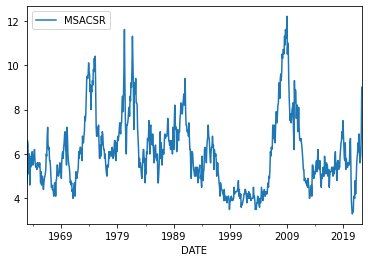

In [7]:
supply_df.plot.line('DATE', 'MSACSR')

plt.savefig('figures/MSACSR_pandas.png')
plt.show()

In [8]:
econ_df = pd.read_csv('data/raw/Macroecon_US.csv')

# Clean col names
econ_df.columns = econ_df.columns.str.strip()

# Remove extraneous columns
econ_df = econ_df.drop(['Date Fraction'], axis=1)  # Date Fraction contains no extra information
econ_df = econ_df.loc[:, ~econ_df.columns.str.contains('^Unnamed')]  # Drop unnamed cols

# Convert object columns to float
non_numeric_cols = econ_df.select_dtypes(include='object').columns
# Commas and % need to be removed for float conversion
econ_df[non_numeric_cols] = econ_df[non_numeric_cols].apply(
                                lambda x: x.str.replace(',|%', '',regex=True).astype(float)
                            )


print(econ_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1817 entries, 0 to 1816
Data columns (total 19 columns):
 #   Column                                                                     Non-Null Count  Dtype  
---  ------                                                                     --------------  -----  
 0   Date                                                                       1817 non-null   float64
 1   S&P Comp.                                                                  1817 non-null   float64
 2   Dividend                                                                   1815 non-null   float64
 3   Earnings                                                                   1812 non-null   float64
 4   Consumer Price Index CPI                                                   1817 non-null   float64
 5   Long Interest Rate GS10                                                    1817 non-null   float64
 6   Real Price                                              

In [9]:
## Convert econ data Dates from object to pd.datetime

# Rename date column to be consistent with other dataframes
econ_df = econ_df.rename(columns={'Date': 'DATE'})

# Get the date column in to a format strftime can handle
econ_df['DATE'] = econ_df['DATE'].apply(lambda x: "{:.2f}".format(x))  # convert to str, keep trailing zeros
econ_df['DATE'] = econ_df['DATE'] + '.01'  # Assume data is from the first of each month
econ_df['DATE'] = econ_df['DATE'].str.replace('.', '-', regex=False)

# Convert to datetime object
econ_df['DATE'] = pd.to_datetime(econ_df['DATE'], format='%Y-%m-%d')

econ_df.head(12)

,DATE,S&P Comp.,Dividend,Earnings,Consumer Price Index CPI,Long Interest Rate GS10,Real Price,Real Dividend,Real Total Return Price,Real Earnings,Real TR Scaled Earnings,Cyclically Adjusted Price Earnings Ratio P/E10 or CAPE,Cyclically Adjusted Total Return Price Earnings Ratio TR P/E10 or TR CAPE,Excess CAPE Yield,Monthly Total Bond Returns,Real Total Bond Returns,10 Year Annualized Stock Real Return,10 Year Annualized Bonds Real Return,Real 10 Year Excess Annualized Returns
0,1871-01-01,4.44,0.26,0.4,12.46,5.32,103.43,6.06,103.43,9.32,9.32,NaN,NaN,NaN,1.0,1.00,13.06,9.25,3.81
1,1871-02-01,4.50,0.26,0.4,12.84,5.32,101.72,5.88,102.21,9.04,9.09,NaN,NaN,NaN,1.0,0.97,13.09,9.46,3.62
2,1871-03-01,4.61,0.26,0.4,13.03,5.33,102.68,5.79,103.66,8.91,8.99,NaN,NaN,NaN,1.0,0.96,13.10,9.62,3.48
3,1871-04-01,4.74,0.26,0.4,12.56,5.33,109.58,6.01,111.13,9.25,9.38,NaN,NaN,NaN,1.0,1.00,12.21,9.10,3.11
4,1871-05-01,4.86,0.26,0.4,12.27,5.33,114.97,6.15,117.11,9.46,9.64,NaN,NaN,NaN,1.0,1.03,12.26,8.95,3.31
5,1871-06-01,4.82,0.26,0.4,12.08,5.34,115.82,6.25,118.51,9.61,9.83,NaN,NaN,NaN,1.0,1.05,12.31,8.77,3.54
6,1871-07-01,4.73,0.26,0.4,12.08,5.34,113.65,6.25,116.83,9.61,9.88,NaN,NaN,NaN,1.0,1.06,12.00,8.66,3.34
7,1871-08-01,4.79,0.26,0.4,11.89,5.34,116.94,6.35,120.75,9.77,10.08,NaN,NaN,NaN,1.0,1.08,11.19,8.27,2.93
8,1871-09-01,4.84,0.26,0.4,12.18,5.35,115.39,6.20,119.68,9.54,9.89,NaN,NaN,NaN,1.0,1.06,11.00,8.10,2.90
9,1871-10-01,4.59,0.26,0.4,12.37,5.35,107.74,6.10,112.28,9.39,9.78,NaN,NaN,NaN,1.0,1.05,11.48,8.17,3.31


### Data Wrangling

In [10]:
# Don't do this because we need as much data as possible

# Sum every 3 months to get cumulative quarterly supply change
#agg_func_supply = {'DATE': 'first', 'MSACSR': 'sum'}  # Keep the first date and sum supply
#quarterly_supply = supply_df.groupby(supply_df.index // 3).agg(agg_func_supply)

# Trim last quarter to match price data length
#quarterly_supply = quarterly_supply[:-1]

# Set date columns to indices for time-series
#quarterly_supply = quarterly_supply.set_index('DATE')
#prices = price_df.set_index('DATE')

#print(quarterly_supply.shape, prices.shape)
#quarterly_supply.head()

### Price Data Interpolation

In [11]:
inter_df = supply_df.merge(price_df, on='DATE', how='left')  # Combine data into df for interpolation
inter_df = inter_df.set_index('DATE')  # Index must be datetime for resampling

print(inter_df.head(10))

            MSACSR    MSPUS
DATE                       
1963-01-01     4.7  17800.0
1963-02-01     6.6      NaN
1963-03-01     6.4      NaN
1963-04-01     5.3  18000.0
1963-05-01     5.1      NaN
1963-06-01     6.0      NaN
1963-07-01     4.6  17900.0
1963-08-01     5.6      NaN
1963-09-01     5.4      NaN
1963-10-01     5.9  18500.0


In [12]:
df_pad = inter_df
df_pad['MSPUS'] = inter_df['MSPUS'].interpolate()

df_pad.head(10)

,MSACSR,MSPUS
DATE,,
1963-01-01,4.7,17800.000000
1963-02-01,6.6,17866.666667
1963-03-01,6.4,17933.333333
1963-04-01,5.3,18000.000000
1963-05-01,5.1,17966.666667
1963-06-01,6.0,17933.333333
1963-07-01,4.6,17900.000000
1963-08-01,5.6,18100.000000
1963-09-01,5.4,18300.000000


In [13]:
econ_df.head()

econ_df.loc[econ_df['DATE'] == '1963-01-01']

,DATE,S&P Comp.,Dividend,Earnings,Consumer Price Index CPI,Long Interest Rate GS10,Real Price,Real Dividend,Real Total Return Price,Real Earnings,Real TR Scaled Earnings,Cyclically Adjusted Price Earnings Ratio P/E10 or CAPE,Cyclically Adjusted Total Return Price Earnings Ratio TR P/E10 or TR CAPE,Excess CAPE Yield,Monthly Total Bond Returns,Real Total Bond Returns,10 Year Annualized Stock Real Return,10 Year Annualized Bonds Real Return,Real 10 Year Excess Annualized Returns
1104,1963-01-01,65.06,2.14,3.68,30.4,3.83,621.38,20.41,73576.49,35.18,4165.49,19.26,22.79,2.71,1.0,11.97,5.94,-0.01,5.95


### Merge Economic Data

In [14]:
df = df_pad.merge(econ_df, on='DATE', how='left')  # Combine data into df for interpolation

df.head(12)
print(df.shape)

(712, 21)


### Simplify Column Names

In [15]:
# Some column names are too long, simplify so easier to work with
print(df.columns)
mapper = {'Consumer Price Index CPI': 'CPI',
          'Cyclically Adjusted Price Earnings Ratio P/E10 or CAPE': 'CAPE',
          'Cyclically Adjusted Total Return Price Earnings Ratio TR P/E10 or TR CAPE': 'Total Return CAPE',
          '10 Year Annualized Stock Real Return': '10 Year Stock Real Return',
          '10 Year Annualized Bonds  Real Return': '10 Year Bonds Real Return',
          'Real 10 Year Excess Annualized  Returns': '10 Year Excess Returns'
         }

df = df.rename(mapper, axis='columns')
print(df.columns)

Index(['DATE', 'MSACSR', 'MSPUS', 'S&P Comp.', 'Dividend', 'Earnings',
       'Consumer Price Index CPI', 'Long Interest Rate GS10', 'Real Price',
       'Real Dividend', 'Real Total Return Price', 'Real Earnings',
       'Real TR Scaled Earnings',
       'Cyclically Adjusted Price Earnings Ratio P/E10 or CAPE',
       'Cyclically Adjusted Total Return Price Earnings Ratio TR P/E10 or TR CAPE',
       'Excess CAPE Yield', 'Monthly Total Bond Returns',
       'Real Total Bond Returns', '10 Year Annualized Stock Real Return',
       '10 Year Annualized Bonds  Real Return',
       'Real 10 Year Excess Annualized  Returns'],
      dtype='object')
Index(['DATE', 'MSACSR', 'MSPUS', 'S&P Comp.', 'Dividend', 'Earnings', 'CPI',
       'Long Interest Rate GS10', 'Real Price', 'Real Dividend',
       'Real Total Return Price', 'Real Earnings', 'Real TR Scaled Earnings',
       'CAPE', 'Total Return CAPE', 'Excess CAPE Yield',
       'Monthly Total Bond Returns', 'Real Total Bond Returns',
       

### Null Values

In [16]:
# Run to see where null values are located by rows
temp_df = df.copy()
pd.reset_option('^display.', silent=True)
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # Print entire dataframe
    nulls = df.copy().isnull().sum(axis=1)
    temp_df['null_locations'] = df.copy().apply(lambda x: ','.join(x[x.isnull()].index), axis=1)
    print(temp_df['null_locations'])
    #print(nulls)

0                                                       
1                                                       
2                                                       
3                                                       
4                                                       
5                                                       
6                                                       
7                                                       
8                                                       
9                                                       
10                                                      
11                                                      
12                                                      
13                                                      
14                                                      
15                                                      
16                                                      
17                             

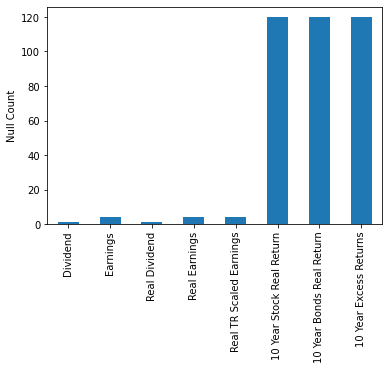

In [17]:
# Plot columns with the most null values

df.isnull().sum()[df.isnull().sum() > 0].plot(kind='bar', ylabel='Null Count')
plt.savefig('figures/null_count_by_column.png', bbox_inches='tight')
plt.show()

In [18]:
# Remove columns with most null values
print(df.isnull().sum())
df = df.drop(['10 Year Stock Real Return', 
              '10 Year Bonds Real Return',
              '10 Year Excess Returns'
             ], axis='columns')
print(df.isnull().sum())

DATE                            0
MSACSR                          0
MSPUS                           0
S&P Comp.                       0
Dividend                        1
Earnings                        4
CPI                             0
Long Interest Rate GS10         0
Real Price                      0
Real Dividend                   1
Real Total Return Price         0
Real Earnings                   4
Real TR Scaled Earnings         4
CAPE                            0
Total Return CAPE               0
Excess CAPE Yield               0
Monthly Total Bond Returns      0
Real Total Bond Returns         0
10 Year Stock Real Return     120
10 Year Bonds Real Return     120
10 Year Excess Returns        120
dtype: int64
DATE                          0
MSACSR                        0
MSPUS                         0
S&P Comp.                     0
Dividend                      1
Earnings                      4
CPI                           0
Long Interest Rate GS10       0
Real Price       

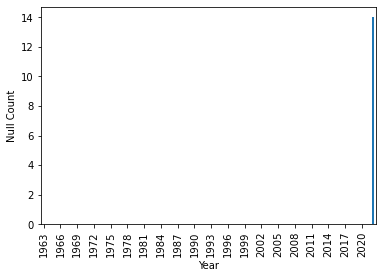

In [19]:
# Plot null count by year

temp_df['null_count'] = df.isnull().sum(axis='columns')
temp_df['Year'] = df['DATE'].dt.year

nulls_by_year = temp_df[['null_count', 'Year']].groupby(by='Year').sum()

#temp_df.plot(x = 'DATE', y = 'null_count')
fig = nulls_by_year.plot.bar(legend=None)
fig.set_xticks(fig.get_xticks()[::3])
fig.set_ylabel('Null Count')

plt.savefig('figures/null_count_by_year.png')
plt.show()

In [20]:
print('Before:', df.shape)
df = df.dropna(axis='index')
print('After:', df.shape)

Before: (712, 18)
After: (708, 18)


In [21]:
df.head(12)

,DATE,MSACSR,MSPUS,S&P Comp.,Dividend,Earnings,CPI,Long Interest Rate GS10,Real Price,Real Dividend,Real Total Return Price,Real Earnings,Real TR Scaled Earnings,CAPE,Total Return CAPE,Excess CAPE Yield,Monthly Total Bond Returns,Real Total Bond Returns
0,1963-01-01,4.7,17800.000000,65.06,2.14,3.68,30.4,3.83,621.38,20.41,73576.49,35.18,4165.49,19.26,22.79,2.71,1.00,11.97
1,1963-02-01,6.6,17866.666667,65.92,2.14,3.70,30.4,3.92,629.59,20.47,74751.05,35.31,4191.90,19.47,23.03,2.60,1.00,11.92
2,1963-03-01,6.4,17933.333333,65.67,2.15,3.71,30.5,3.93,625.15,20.47,74425.91,35.32,4204.66,19.29,22.81,2.63,1.00,11.91
3,1963-04-01,5.3,18000.000000,68.76,2.17,3.75,30.5,3.97,654.56,20.63,78132.53,35.73,4264.94,20.15,23.82,2.37,1.01,11.91
4,1963-05-01,5.1,17966.666667,70.14,2.18,3.80,30.5,3.93,667.70,20.78,79907.38,36.14,4325.38,20.51,24.23,2.29,1.00,11.98
5,1963-06-01,6.0,17933.333333,70.11,2.20,3.84,30.6,3.99,665.23,20.87,79820.36,36.44,4371.85,20.38,24.08,2.25,1.00,11.93
6,1963-07-01,4.6,17900.000000,69.07,2.20,3.88,30.7,4.02,653.23,20.84,78588.54,36.70,4414.70,19.97,23.58,2.36,1.00,11.90
7,1963-08-01,5.6,18100.000000,70.98,2.21,3.92,30.7,4.00,671.29,20.87,80970.99,37.07,4471.77,20.47,24.16,2.21,1.00,11.96
8,1963-09-01,5.4,18300.000000,72.85,2.21,3.96,30.7,4.08,688.98,20.90,83314.29,37.45,4528.82,20.96,24.73,2.02,1.00,11.92
9,1963-10-01,5.9,18500.000000,73.03,2.23,3.98,30.8,4.11,688.44,21.05,83461.13,37.52,4548.48,20.89,24.63,2.00,1.00,11.89


### EDA

<AxesSubplot:>

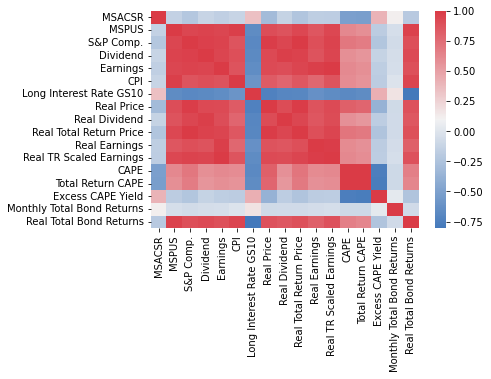

In [22]:
corr = df.corr(method='pearson')
cmap = sns.diverging_palette(250, 10, as_cmap=True)
heatmap = sns.heatmap(corr, cmap=cmap)

heatmap_fig = heatmap.get_figure()
heatmap_fig.savefig("figures/feature_corr_heatmap.png", bbox_inches='tight')
heatmap

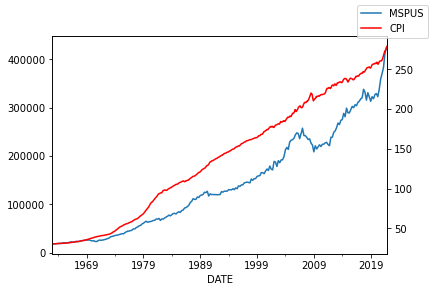

In [23]:
ax = df.plot(x='DATE', y='MSPUS', legend=False)
ax2 = ax.twinx()
df.plot(x='DATE', y='CPI', ax=ax2, legend=False, color='r')
ax.figure.legend()
plt.show()

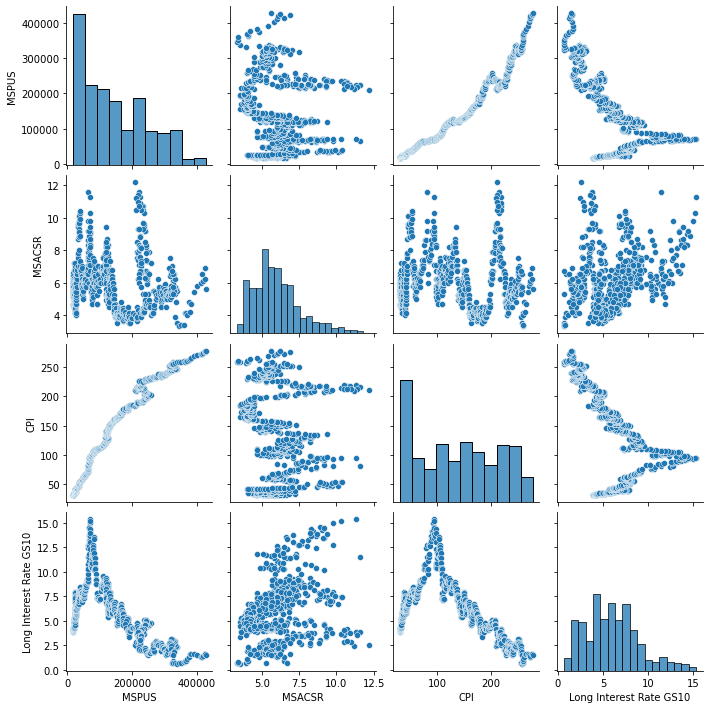

In [24]:
pairplot = sns.pairplot(df[['MSPUS', 'MSACSR', 'CPI', 'Long Interest Rate GS10']])

pairplot.savefig("figures/pairplot.png", bbox_inches='tight')
pairplot

In [25]:
# Test for stationerity

If data shows a strong trend or seasonality, it is not stationary.

Price data is not stationary

Differencing is one way to make stationary for classical models

1        66.666667
2        66.666667
3        66.666667
4       -33.333333
5       -33.333333
          ...     
703    4133.333333
704    4133.333333
705    4133.333333
706    1700.000000
707    1700.000000
Name: MSPUS, Length: 707, dtype: float64


<AxesSubplot:>

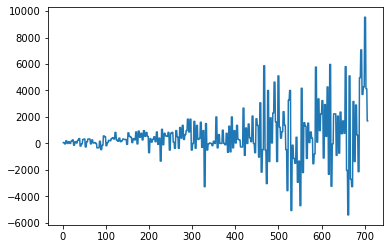

In [26]:
temp_df = df.copy()
temp_df['price_diff'] = df['MSPUS'].diff().dropna()

temp_df.plot.line('DATE', 'Price Difference')

plt.savefig('figures/MSACSR_pandas.png')
plt.show()

After running the difference between each successive entry in the price series, we can see that the variance increases as time goes on. 

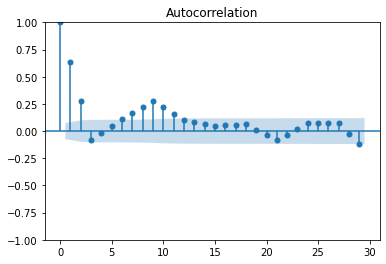

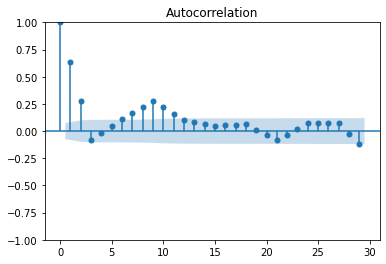

In [27]:
sm.graphics.tsa.plot_acf(price_diff)

507 200
Iteration:      1,   Func. Count:     23,   Neg. LLF: 1845.0967640961517
Iteration:      2,   Func. Count:     46,   Neg. LLF: 1727.744037800371
Iteration:      3,   Func. Count:     69,   Neg. LLF: 1754.643063996819
Iteration:      4,   Func. Count:     92,   Neg. LLF: 1726.7174568798384
Iteration:      5,   Func. Count:    115,   Neg. LLF: 1746.291200527167
Iteration:      6,   Func. Count:    138,   Neg. LLF: 1712.9874815397047
Iteration:      7,   Func. Count:    160,   Neg. LLF: 1711.3817846548404
Iteration:      8,   Func. Count:    182,   Neg. LLF: 1717.8159548514361
Iteration:      9,   Func. Count:    206,   Neg. LLF: 1710.2976720610627
Iteration:     10,   Func. Count:    228,   Neg. LLF: 1709.372972454887
Iteration:     11,   Func. Count:    250,   Neg. LLF: 1708.6080355833315
Iteration:     12,   Func. Count:    272,   Neg. LLF: 1708.5015643867655
Iteration:     13,   Func. Count:    294,   Neg. LLF: 1708.4814491162076
Iteration:     14,   Func. Count:    316,   Neg

/home/harrison/anaconda3/envs/mas-thesis/lib/python3.10/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


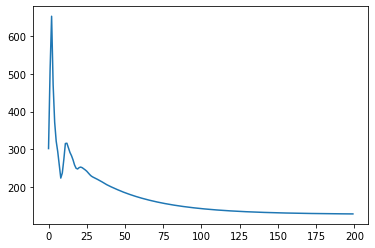

In [28]:
# Try a simple GARCH model
# Autoregressivice Conditional Heteroskedasticity
# Used to predict volatility

# Zero mean for model
price_diff = price_diff - price_diff.mean()

TEST_SIZE = 200
train, test = price_diff[:-TEST_SIZE], price_diff[-TEST_SIZE:]
print(len(train), len(test))

# TODO: experiment with p, q values (lag order of symmetric innovation, lagged volatility respectively) 
# AIC is recommended for forecasting, BIC for explanatory modeling
# Used p,q=10 because that is where we see significant autocorrelation
model = arch_model(train, mean='Zero', vol='GARCH', p=10, q=10, rescale=True)  # Auto rescale values for optimizer
fitted = model.fit()

yhat = fitted.forecast(horizon=TEST_SIZE)
plt.plot(yhat.variance.values[-1, :])
plt.show()

In [29]:
# TODO: Pair GARCH with ARIMA to get simple predictions

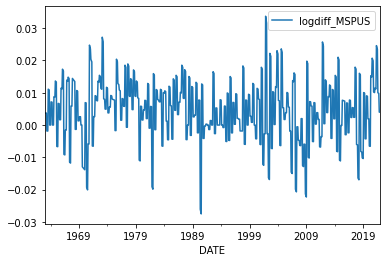

In [30]:
# Try with log diff (can also be thought of as log returns)

# Math note: log(P[t] / P[t-1]) = logP[t] - logP[t-1]
log_diff = np.log( df['MSPUS'] / df['MSPUS'].shift(1) ).dropna()
df['logdiff_MSPUS'] = log_diff

df.plot.line('DATE', 'logdiff_MSPUS')

plt.savefig('figures/logdiff_MSPUS.png')
plt.show()

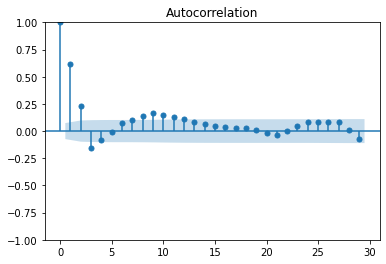

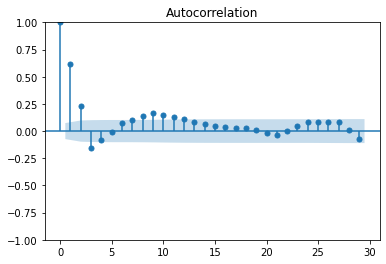

In [31]:
auto_corr = sm.graphics.tsa.plot_acf(log_diff)

auto_corr.savefig("figures/autocorrelation_mspus_tr.png", bbox_inches='tight')
auto_corr

### Save Processed Data

In [32]:
# Pickle saves exact dataframe for python to load later
df.to_pickle('data/processed.pkl')

# Save to csv for Rstudio
df.to_csv('data/processed.csv')